### Sexto ejercicio

Utilizando la funcion `generate_outliers` generar puntos extremos dentro de los datos que generamos anteriormente. En este ejercicio dejar setteado `extreme_outliers` como `False` y observe como variando el porcentaje de los mismos la regresión comienza a afectarse.

Pasos:

1. Generar datasets:
    - Uno normal con poco `noise` y pocos outliers
    - Uno con mucho `noise` y pocos outliers
    - Uno con poco `noise` y muchos outliers
    - Uno con mucho `noise` y muchos outliers
2. Probar los distintos regresores a ver como se comportan frente a estos datasets anómalos.
3. Comparar y analizar resultados.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression

# Evaluación de modelos de prueba
from sklearn.metrics import mean_squared_error

# Crear datasets
from sklearn.datasets import make_regression

In [21]:
#Funcion auxiliares para generar datos anomalos
def generate_outliers(df: pd.DataFrame,
                     cols: list = None,
                     extreme_outlier: bool = False,
                     two_tailed: bool = False,
                     percentage: float = 0.02) -> pd.DataFrame:
  """Con esta función vamos a poder generar outliers en ciertas columnas de nuestro
  dataset. Si le damos True a _extreme_outlier_ va a generar outliers con mucho
  peso en la regresión (puede ser bilateral o unilateral segun _two_tailed_)
  """  
  seeds = np.random.randint(100, size = len(df))
  
  nsamples = np.math.floor(len(df) * percentage)
  idx_to_change = df.sample(n = nsamples).index

  cols = df.columns.tolist() if cols is None else cols

  result = df.copy(deep = True)
  
  for i,col_name in enumerate(cols):
    np.random.seed(seeds[i])

    iqr = result[col_name].quantile(0.75) - result[col_name].quantile(0.25)

    lb = result[col_name].quantile(0.25) - 1 * iqr
    ub = result[col_name].quantile(0.75) + 1 * iqr

    if two_tailed:
      outs = result[col_name].loc[(result[col_name] < lb) | (result[col_name] > ub)]
    else:
      outs = result[col_name].loc[(result[col_name] > ub)]
    
    out_size = len(outs)
    if out_size < nsamples:
      nsamples = out_size

    idx_to_change = outs.sample(nsamples, replace = False).index
    
    if extreme_outlier:
      outlier_sign = [1 if np.random.random() < 0.9 else -1 for _ in range(nsamples)]
      
      result[col_name].loc[idx_to_change] = np.multiply(outlier_sign,
                                                        np.random.uniform(low = result[col_name].mean(),
                                                                          high = result[col_name].max()*5,
                                                                          size = nsamples)
                                                        )
      result['target'].loc[idx_to_change] = np.multiply(outlier_sign,
                                                        np.random.uniform(low = result['target'].mean(),
                                                                          high = result['target'].max()*2,
                                                                          size = nsamples)
                                                        )
    else:
      samples = result[col_name].loc[idx_to_change].values
      np.random.shuffle(samples)
      result[col_name].loc[idx_to_change] = samples
  
  return result

In [22]:
#Creamos una funcion para crear los datos 

def dataset(samples,noise,feature,informative):
    X, y = make_regression(n_samples = samples,
                       n_features = feature,
                       noise = noise,
                       n_informative = informative,
                       random_state = 42)

    new_data = np.append(X,y.reshape(-1,1),axis=1)
    df = pd.DataFrame(new_data)

    new_col = []
    i = 0
    for col in df.columns:
        if i ==  len(df.columns) - 1:
            new_col.append("target")
        else :
            new_col.append("feature_" + str(i+1))
        
        i += 1
    
    df.columns = new_col

    return df

In [23]:
def graficar(df,columnas):
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    for i, columna in enumerate(columnas):
        sns.scatterplot(x=columna, y='target', hue='target', data=df, ax=axes[i//2, i%2])
        axes[i//2, i%2].set_title(columna)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2, wspace=0.1)

    plt.show()

1. Generar datasets:
    - Uno normal con poco `noise` y pocos outliers
    - Uno con mucho `noise` y pocos outliers
    - Uno con poco `noise` y muchos outliers
    - Uno con mucho `noise` y muchos outliers

In [24]:
#llamo a la funcion dataset
## Utilicen mas `n_features` > 1 y n_informative mas o menos la mitad de n_features

#Creo dos dataset con mucho y poco ruido 

data_nb= dataset(1000,1,4,3);
data_nm= dataset(1000,2000,4,3);

#
columnas = [col for col in data_nb.columns ]
columnas = columnas[:len(columnas)-1]

#Aplico los bajo outliers al dataset con bajoruido

df_outlier_bj_nb = generate_outliers(data_nb,columnas, percentage = 0.05, extreme_outlier = False, two_tailed= True)
df_outlier_bj_nm = generate_outliers(data_nm,columnas, percentage = 0.05, extreme_outlier = False, two_tailed= True)

#Aplico los mucho outliers al dataset con bajoruido

df_outlier_mj_nb = generate_outliers(data_nb,columnas, percentage = 0.85, extreme_outlier = False, two_tailed= True)
df_outlier_mj_nm = generate_outliers(data_nm,columnas, percentage = 0.85, extreme_outlier = False, two_tailed= True)


Grafico de datos originales sin aplicar outliers

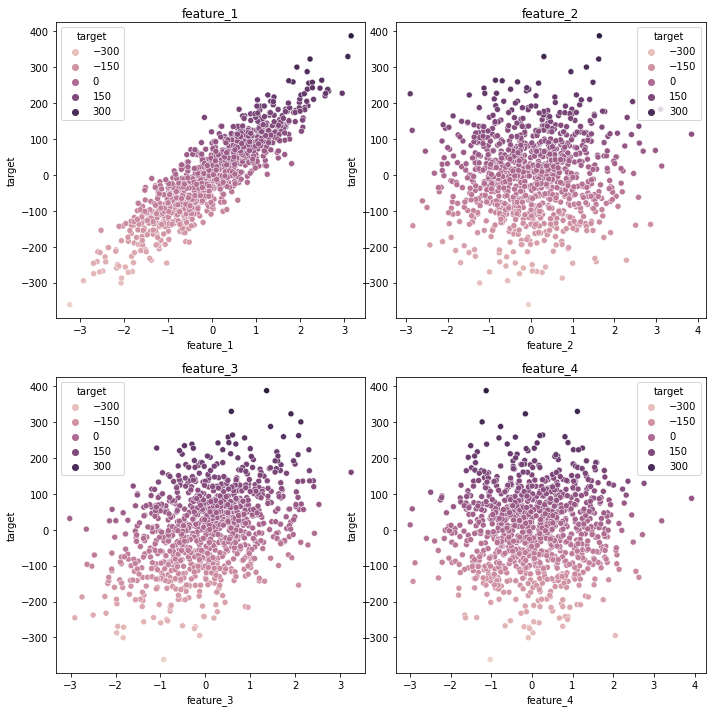

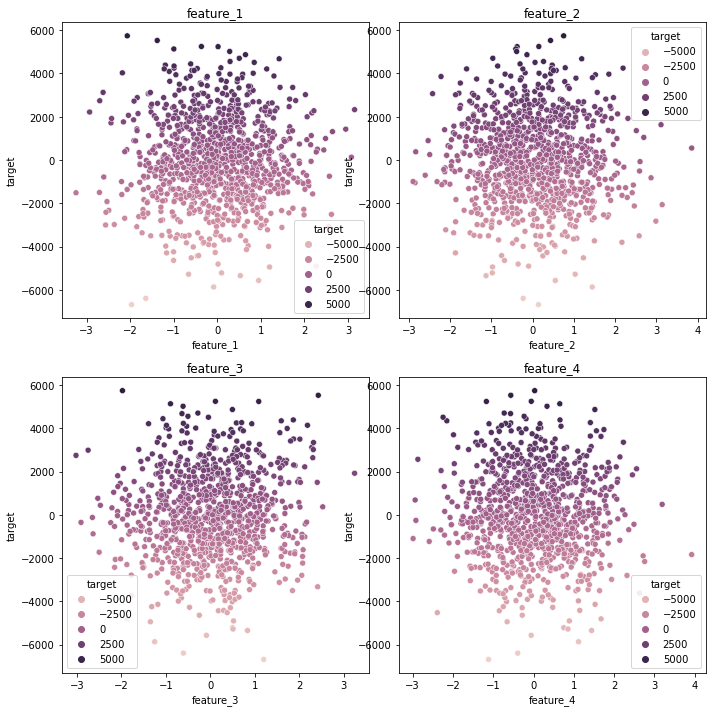

In [25]:
graficar(data_nb,columnas)
graficar(data_nm,columnas)

Al agregar ruido a los datos, se pueden notar diferencias en el gráfico, ya que las muestras se expanden en el eje objetivo. Por ejemplo, cuando el ruido es igual a 1, las muestras se mantienen en un rango estrecho de [-300, 300], mientras que con un ruido de 2000, las muestras se expanden ampliamente en un rango de [-5000, 5000]. Además, es importante destacar que la dispersión no es uniforme para todas las características, lo que puede afectar la capacidad de los modelos para capturar la relación entre las variables.

Graficos outliers bajo en dataset 


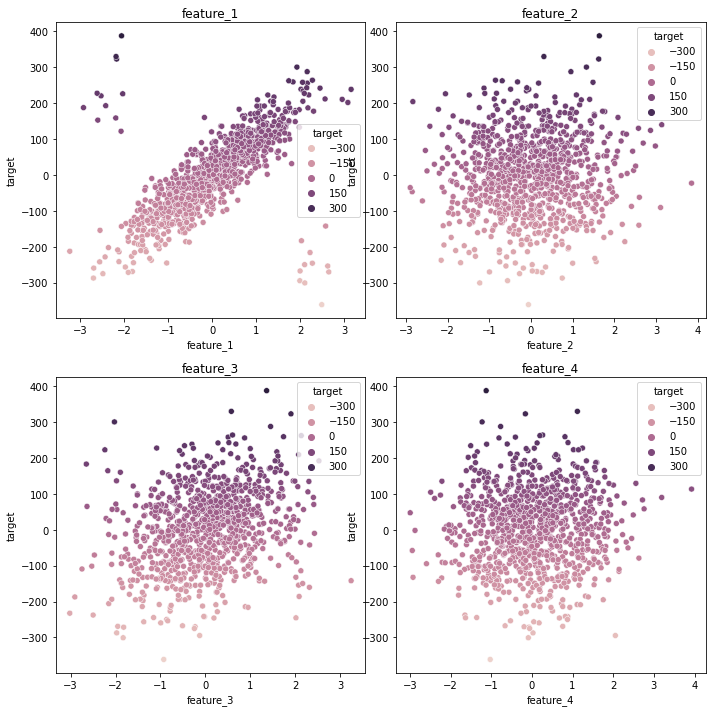

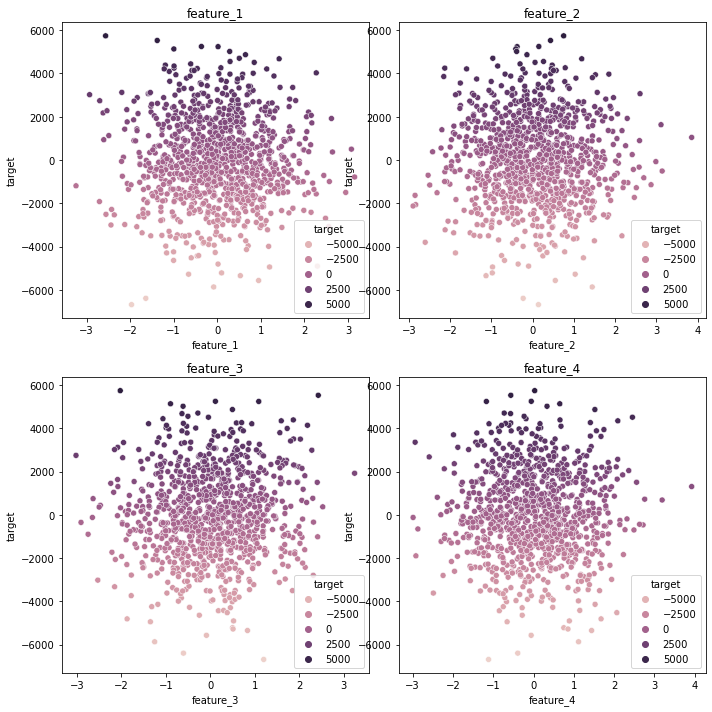

In [26]:
graficar(df_outlier_bj_nb, columnas)
graficar(df_outlier_bj_nm, columnas)


Al observar los gráficos generados a partir de los datos simulados y del dataset original, no se observa una gran modificación en las muestras al utilizar un porcentaje de outliers de 0.05 y extreme_outliers en falso. Esto puede deberse a que la magnitud del porcentaje utilizado es relativamente bajo y que la cantidad de datos en el dataset es lo suficientemente grande para minimizar el efecto de los outliers. Aunque se pueden observar algunos puntos esparcidos que representan posibles outliers, estos no parecen tener un impacto significativo en los datos.

Grafico con mucho outliers

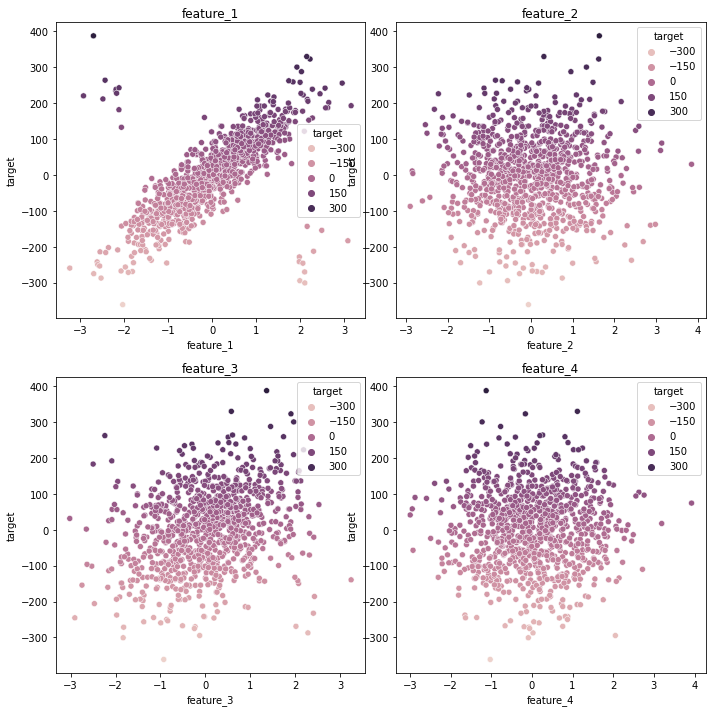

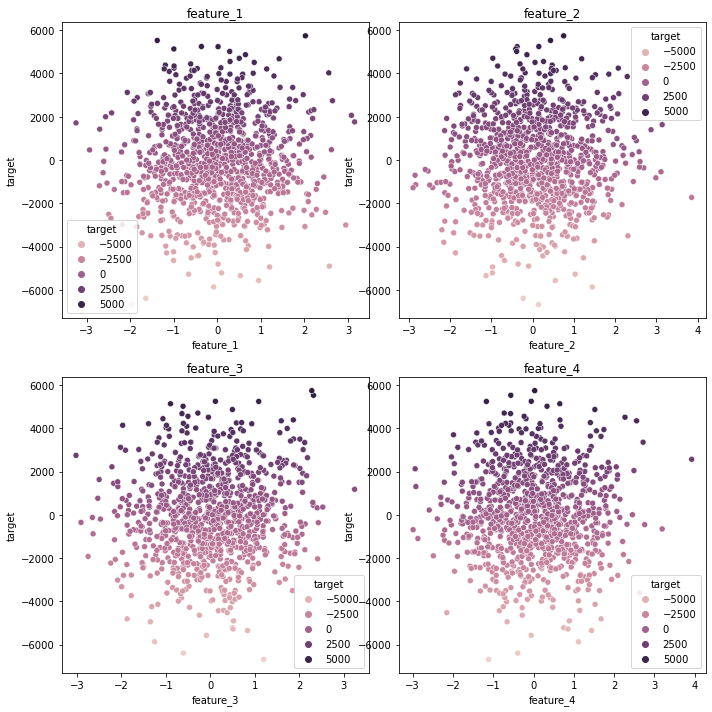

In [27]:
graficar(df_outlier_mj_nb,columnas)
graficar(df_outlier_mj_nm,columnas)

Al observar los gráficos generados a partir de los datos simulados y del dataset original, se puede observar que el aumento del porcentaje de outliers a 0.85 no produce una gran diferencia  en la distribución de las muestras en comparación con un porcentaje de 0.05 y extreme_outliers en falso. Esto puede deberse a que la cantidad de datos en el dataset es lo suficientemente grande como para minimizar el efecto de los outliers. Aunque se pueden observar algunos puntos esparcidos que representan posibles outliers, estos no parecen tener un impacto significativo en los datos. En general, se puede concluir que el porcentaje de outliers utilizado en este caso no tiene un efecto significativo en los resultados, lo que sugiere que los datos originales son relativamente robustos ante la presencia de outliers.

Probemos los distintos regresores a ver como se comportan frente a estos datasets anómalos.

In [36]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, HuberRegressor, ElasticNetCV
import matplotlib.pyplot as plt
import seaborn as sns


def apply_regressors(df,eje_x):
    # Separar datos en conjunto de entrenamiento y prueba
    X_train, y_train = df.iloc[:800, :-1], df.iloc[:800, -1]
    X_test, y_test = df.iloc[800:, :-1], df.iloc[800:, -1]
    
    # Regresión Lineal
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_score = lr.score(X_test, y_test)

    # Regresión Huber
    huber = HuberRegressor()
    huber.fit(X_train, y_train)
    huber_score = huber.score(X_test, y_test)

    # Regresión ElasticNet
    elastic = ElasticNetCV(cv=5)
    elastic.fit(X_train, y_train)
    elastic_score = elastic.score(X_test, y_test)

    # Imprimir resultados
    print("R2 score Regresión Lineal:", lr_score)
    print("R2 score Regresión Huber:", huber_score)
    print("R2 score Regresión ElasticNet:", elastic_score)

    # Crear gráfico con los datos y las líneas de regresión de cada modelo
    sns.lmplot(data=df,
               x=eje_x,
               y='target',
               height=5,
               aspect=2,
               ci=None,
               scatter_kws={"s": 30},
               line_kws={"lw": 2},
               order=1)

    sns.regplot(x=X_test[eje_x], y=lr.predict(X_test), ci=None, scatter=False, color='green')
    sns.regplot(x=X_test[eje_x], y=huber.predict(X_test), ci=None, scatter=False, color='red')
    sns.regplot(x=X_test[eje_x], y=elastic.predict(X_test), ci=None, scatter=False, color='purple')

    plt.legend(['Datos', 'Regresión Lineal', 'Regresión Huber', 'Regresión ElasticNet'])
    plt.show()



R2 score Regresión Lineal: 0.6280123115128784
R2 score Regresión Huber: 0.5858850592583897
R2 score Regresión ElasticNet: 0.619144664220658


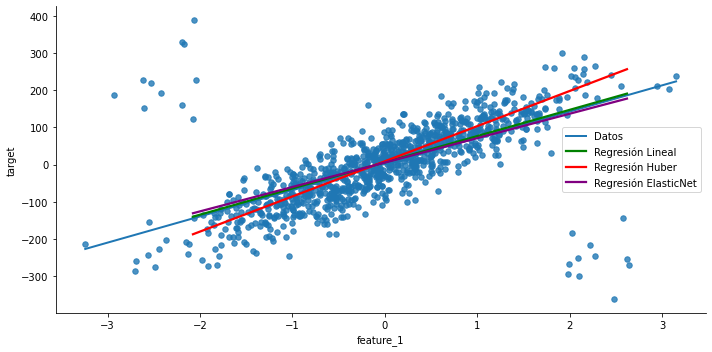

R2 score Regresión Lineal: 0.999891870422788
R2 score Regresión Huber: 0.9998920697813892
R2 score Regresión ElasticNet: 0.9910653347812386


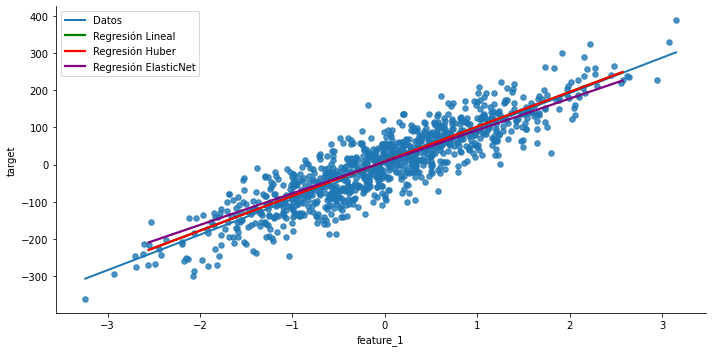

R2 score Regresión Lineal: 0.6280123115128784
R2 score Regresión Huber: 0.5858850592583897
R2 score Regresión ElasticNet: 0.619144664220658


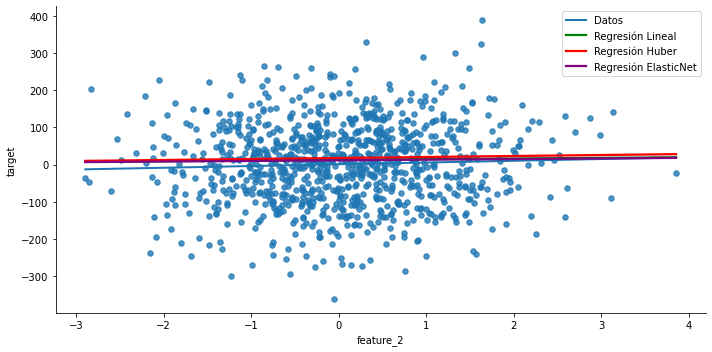

R2 score Regresión Lineal: 0.999891870422788
R2 score Regresión Huber: 0.9998920697813892
R2 score Regresión ElasticNet: 0.9910653347812386


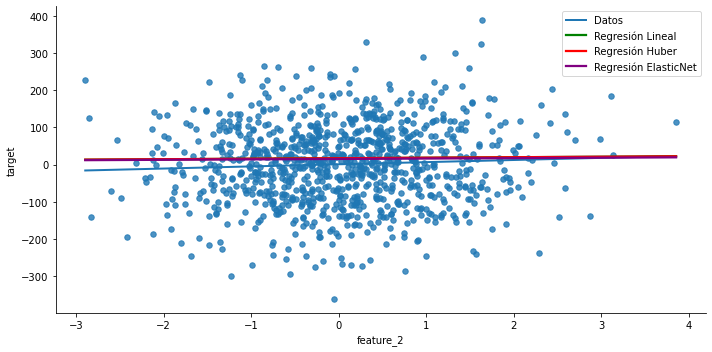

In [37]:

apply_regressors(df_outlier_bj_nb,'feature_1')
apply_regressors(data_nb,'feature_1')


apply_regressors(df_outlier_bj_nb,'feature_2')
apply_regressors(data_nb,'feature_2')

R2 score Regresión Lineal: -0.010452781887154039
R2 score Regresión Huber: -0.008958761205176247
R2 score Regresión ElasticNet: -6.202282764178335e-05


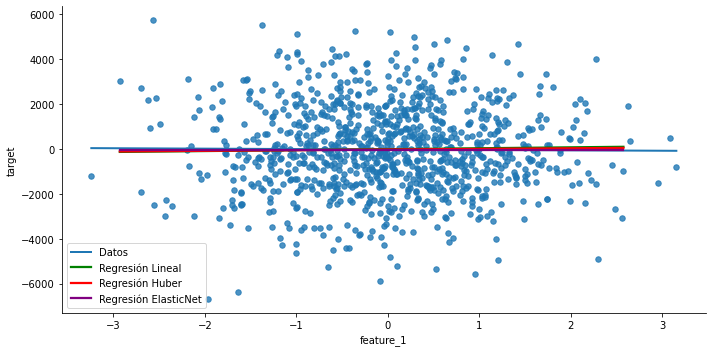

R2 score Regresión Lineal: -0.003352041283008367
R2 score Regresión Huber: -0.0015009118275426392
R2 score Regresión ElasticNet: 0.00020187029366769416


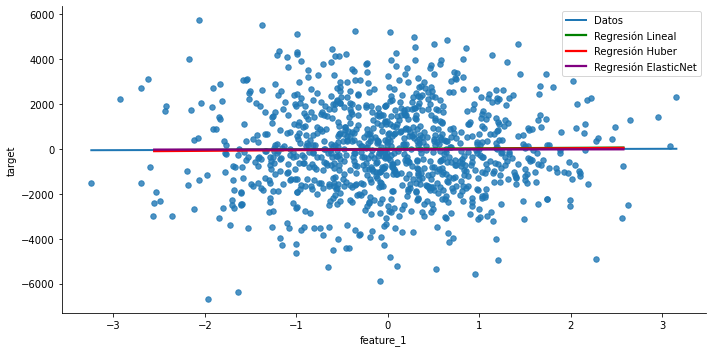

R2 score Regresión Lineal: -0.010452781887154039
R2 score Regresión Huber: -0.008958761205176247
R2 score Regresión ElasticNet: -6.202282764178335e-05


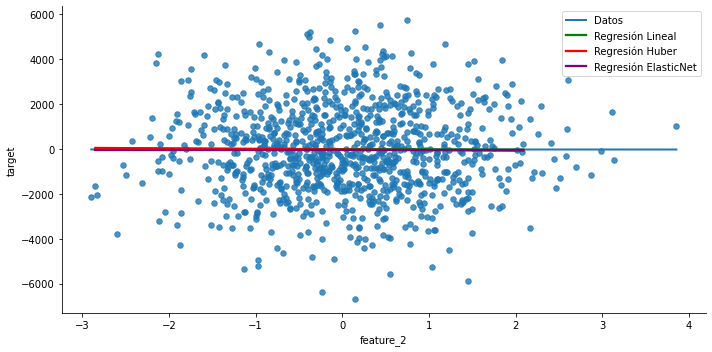

R2 score Regresión Lineal: -0.003352041283008367
R2 score Regresión Huber: -0.0015009118275426392
R2 score Regresión ElasticNet: 0.00020187029366769416


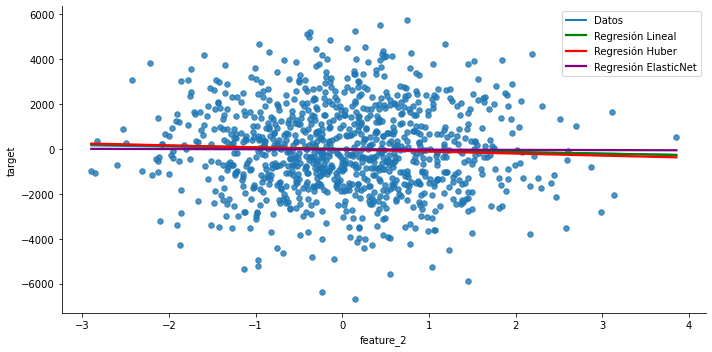

In [39]:

apply_regressors(df_outlier_bj_nm,'feature_1')
apply_regressors(data_nm,'feature_1')


apply_regressors(df_outlier_bj_nm,'feature_2')
apply_regressors(data_nm,'feature_2')

R2 score Regresión Lineal: 0.6862270106051283
R2 score Regresión Huber: 0.6784533000113298
R2 score Regresión ElasticNet: 0.6757554320530956


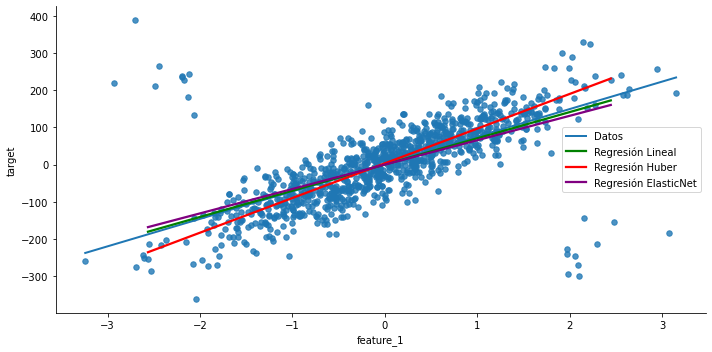

R2 score Regresión Lineal: 0.999891870422788
R2 score Regresión Huber: 0.9998920697813892
R2 score Regresión ElasticNet: 0.9910653347812386


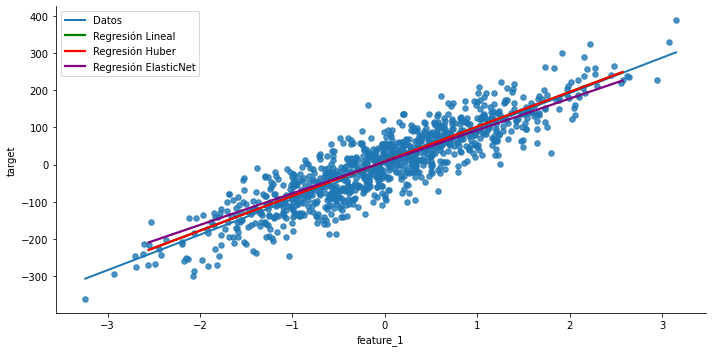

R2 score Regresión Lineal: 0.6862270106051283
R2 score Regresión Huber: 0.6784533000113298
R2 score Regresión ElasticNet: 0.6757554320530956


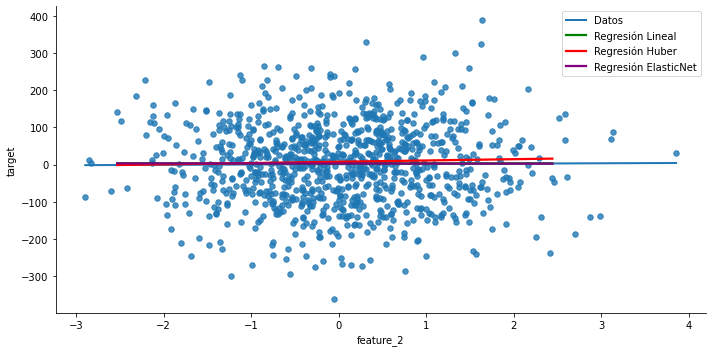

R2 score Regresión Lineal: 0.999891870422788
R2 score Regresión Huber: 0.9998920697813892
R2 score Regresión ElasticNet: 0.9910653347812386


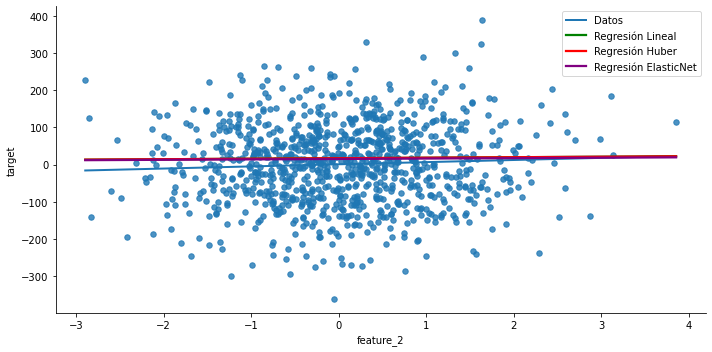

In [40]:

apply_regressors(df_outlier_mj_nb,'feature_1')
apply_regressors(data_nb,'feature_1')


apply_regressors(df_outlier_mj_nb,'feature_2')
apply_regressors(data_nb,'feature_2')

R2 score Regresión Lineal: -0.010452781887154039
R2 score Regresión Huber: -0.008958761205176247
R2 score Regresión ElasticNet: -6.202282764178335e-05


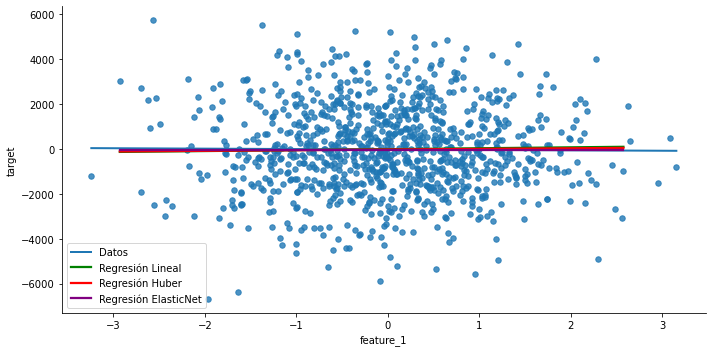

R2 score Regresión Lineal: -0.003352041283008367
R2 score Regresión Huber: -0.0015009118275426392
R2 score Regresión ElasticNet: 0.00020187029366769416


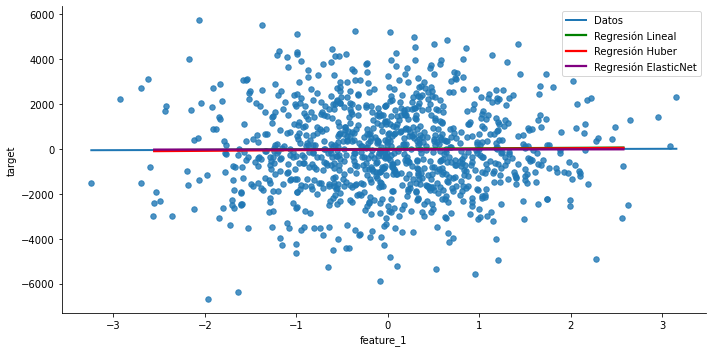

R2 score Regresión Lineal: -0.010452781887154039
R2 score Regresión Huber: -0.008958761205176247
R2 score Regresión ElasticNet: -6.202282764178335e-05


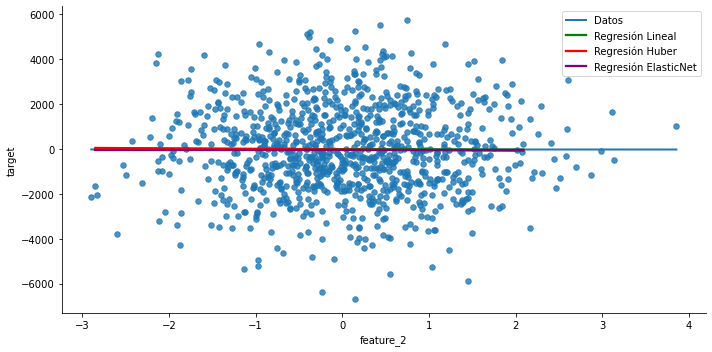

R2 score Regresión Lineal: -0.003352041283008367
R2 score Regresión Huber: -0.0015009118275426392
R2 score Regresión ElasticNet: 0.00020187029366769416


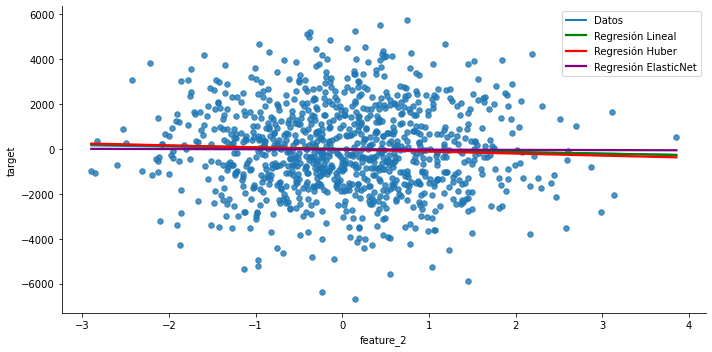

In [41]:

apply_regressors(df_outlier_bj_nm,'feature_1')
apply_regressors(data_nm,'feature_1')


apply_regressors(df_outlier_bj_nm,'feature_2')
apply_regressors(data_nm,'feature_2')